<h1>Pixel-based Image Enhancement Algorithms</h1>
<h3>Rodrigo Ildefonso Roman Guzman</h3>


## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage import exposure
import skimage
from skimage import img_as_ubyte
from scipy.ndimage import gaussian_filter as gauss
from scipy.ndimage import median_filter as med

import cv2



**What is the tile-based histogram equalization method?**

The method known as "tile-based histogram equalization" or also referred to as adaptive histogram equalization (AHE)

It is a digital image processing technique used to enhance the contrast of images.

It differs from normal histogram equalization in that the adaptive method enhances contrast locally. It divides the image into distinct blocks and computes the histogram equalization for each section. Therefore, AHE calculates many histograms, each corresponding to a different section of the image.

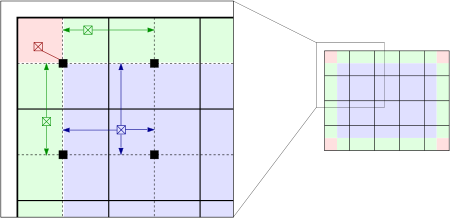

It enhances local contrast and the definitions of edges in all distinct regions of the image.

It has the disadvantage that it generally tends to leave marks of the blocks used on the image and can take up a lot of computational resources depending on the size of the blocks and the size of the image being used.

In [2]:


def slice_image(image, num_rows, num_cols):
    rows, cols = image.shape
    tile_height = rows // num_rows
    tile_width = cols // num_cols
    tiles = []
    for i in range(num_rows):
        for j in range(num_cols):
            tile = image[i * tile_height:(i + 1) * tile_height, j * tile_width:(j + 1) * tile_width]
            tiles.append(tile)
    return tiles

In [3]:

def join_tiles(tiles, num_rows, num_cols):
    tile_height, tile_width = tiles[0].shape
    image = np.zeros((tile_height * num_rows, tile_width * num_cols), dtype=tiles[0].dtype)
    for i in range(num_cols):
        for j in range(num_rows):
            image[j * tile_height:(j + 1) * tile_height, i * tile_width:(i + 1) * tile_width] = tiles[j * num_cols + i]
    return image

In [4]:

def equalize_hist_grayscale(image):
    return img_as_ubyte(exposure.equalize_hist(image))

Image loaded successfully. Shape: (720, 1280)


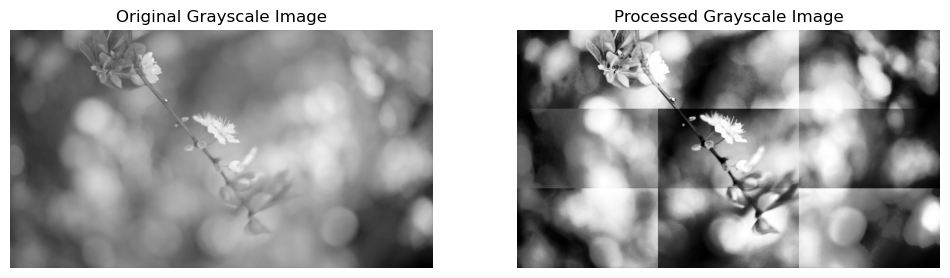

In [5]:


# Load the image and convert to grayscale
img_path = 'images/leaf.jpg'
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully. Shape:", original.shape)

# Define the number of rows and columns for slicing
num_rows, num_cols = 3, 3
tiles = slice_image(original, num_rows, num_cols)

# Process each tile
processed_tiles = []
for tile in tiles:
    equ = equalize_hist_grayscale(tile)  # Apply histogram equalization directly on the grayscale image
    processed_tiles.append(equ)

# Reassemble the image from processed tiles
joined_image = join_tiles(processed_tiles, num_rows, num_cols)

# Display the original and processed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Processed Grayscale Image")
plt.imshow(joined_image, cmap='gray')
plt.axis('off')

plt.show()




We will do the same, but we will increase the resolution of the image and the number of blocks calculated.


Image loaded successfully. Shape: (720, 1280)


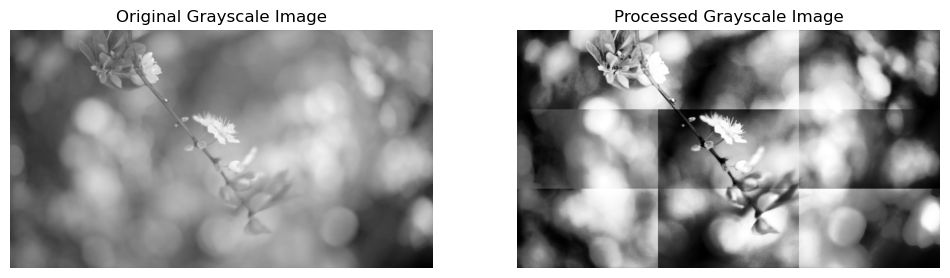

In [7]:


# Load the image and convert to grayscale
img_path = 'images/leaf.jpg'
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully. Shape:", original.shape)

# Resize the image
target_size = (1920, 1080)
resized_image = cv2.resize(original, target_size)

# Define the number of rows and columns for slicing
num_rows, num_cols = 3, 3
tiles = slice_image(resized_image, num_rows, num_cols)

# Process each tile
processed_tiles = []
for tile in tiles:
    equ = equalize_hist_grayscale(tile)
    processed_tiles.append(equ)

# Reassemble the image from processed tiles
joined_image = join_tiles(processed_tiles, num_rows, num_cols)

# Display the original and processed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(resized_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Processed Grayscale Image")
plt.imshow(joined_image, cmap='gray')
plt.axis('off')

plt.show()

The image now has a size of: 1920 x 1080, essentially 0.5 times larger than the original.

Image loaded successfully. Shape: (1080, 1920)


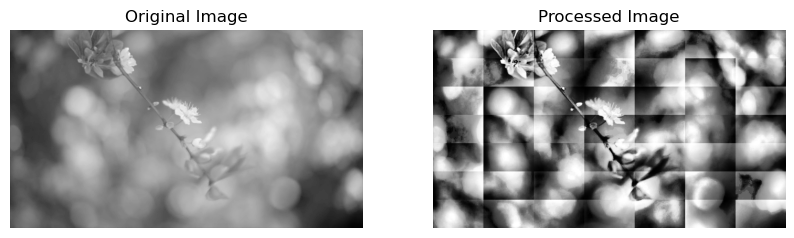

In [12]:

# Load the image in grayscale
img_path = 'images/leaf_scaled.jpg'
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully. Shape:", original.shape)

# Define the number of rows and columns for slicing
p = 56  # Number of partitions
num_rows = num_cols = int(np.sqrt(p))  # Here we assume that p is a perfect square
tiles = slice_image(original, num_rows, num_cols)

# Process each tile
processed_tiles = []
for tile in tiles:
    equ = equalize_hist_grayscale(tile)
    processed_tiles.append(equ)

# Reassemble the image from processed tiles
final_image = join_tiles(processed_tiles, num_rows, num_cols)

# Display the original and processed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Processed Image")
plt.imshow(final_image, cmap='gray')
plt.axis('off')

plt.show()


Now we can observe that due to the tone of each histogram in each block, each one is processed differently and the difference is quite noticeable, especially in the upper part where you can see a bit of noise that remains in each block.

**How could it be improved?**

AHE has a tendency to over-amplify noise in relatively homogeneous regions of an image, not to mention that the squares or blocks within the image are usually noticeable.

One way to solve this would be similar to the implementation of limited contrast.

The implementation of limited contrast (CL) limits amplification by clipping the histogram at a predefined value before calculating the CDF.

This clipping or excess is applied to the rest of the histogram and then the CDF is applied.

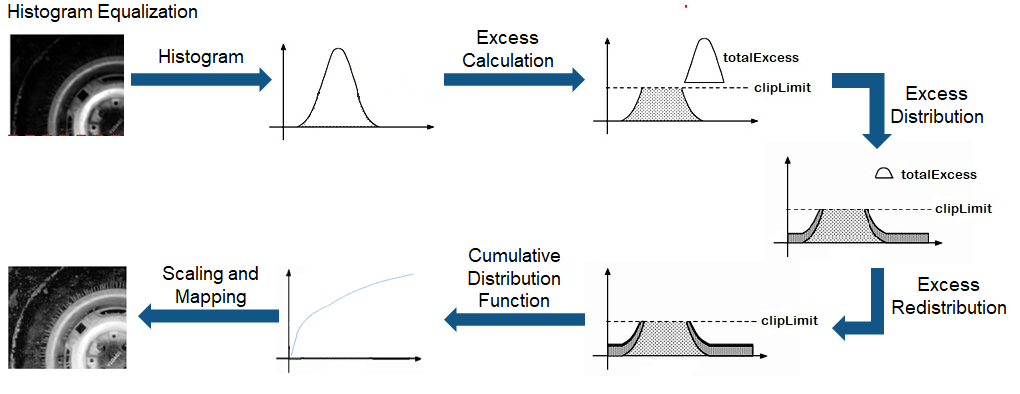

This limits the slope of the CDF and therefore the transformation function, which helps to smooth the image and each block into which it was divided.


# Part 2

**Sliding Window Adaptive Histogram Equalization** (SWAHE) is a histogram equalization technique used to enhance contrast in images with an uneven distribution of brightness. This technique involves adaptively applying histogram equalization to an image, using a sliding window to compute the histogram for each section of the image.

**SWAHE** is useful for correcting images with an uneven distribution of brightness, such as images with shadows or both illuminated and dark areas. The technique is particularly beneficial for microscopy and satellite images, where uneven brightness distribution is common.

Some applications of SWAHE include:

* Enhancing visibility in microscopy and satellite images.

* Correcting images with shadows and areas that are both illuminated and dark.

* Increasing clarity in images with an uneven distribution of brightness.

* Improving the accuracy of image analysis, such as object detection or image segmentation.

* Enhancing image visualization in medical applications and health monitoring.

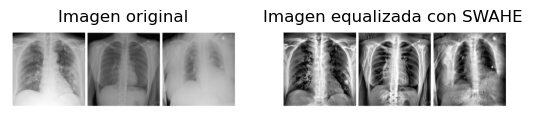

In [13]:
# Load the image
img = cv2.imread('images/Torax.png')

# Change to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply CLAHE
clahe = cv2.createCLAHE(tileGridSize=(12, 12))
equalized_image = clahe.apply(gray)

# Save the result image
cv2.imwrite('images/Torax_swahe.jpg', equalized_image)

# Show original and modified image
plt.subplot(121), plt.imshow(gray, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(122), plt.imshow(equalized_image, cmap='gray')
plt.title('Imagen equalizada con SWAHE')
plt.axis('off')

plt.show()


<h4>CLAHE (Contrast Limited Adaptive Histogram Equalization) </h4> is an image enhancement algorithm used to improve contrast in images with non-uniform lighting. The algorithm is based on the Adaptive Histogram Equalization (AHE) algorithm, which is a variation of traditional histogram equalization that divides the image into small regions (called "tiles") and applies histogram equalization to each tile independently. However, the CLAHE algorithm includes a contrast limitation mechanism to prevent excessive amplification of noise present in the image.
The algorithm is divided into the following steps:
<ol>
<li>
Divide the image into small regions, known as tiles. These tiles are used to calculate the histogram for each region.
</li>
<li>
Calculate the histogram for each tile and use it to compute the local histogram equalization function for that tile.
</li>
<li>
Apply the local histogram equalization function to each pixel within its corresponding tile.
</li>
<li>
Use a contrast limit to prevent excessive noise amplification in the image. The contrast limit is used to cap the difference between the value of a pixel and that of its neighbor.
</li>
<li>
Interpolate pixel values between tiles to smooth transitions.
</li>
<li>
Apply a Gaussian filter to smooth the final image.
</li>
</ol>
The advantage of CLAHE is that it can enhance contrast in areas of the image where lighting is non-uniform, whereas AHE tends to produce artifacts and overexposure in these areas. The disadvantage of CLAHE is that it tends to generate more noise in the image if an appropriate contrast limit is not used.

<h2><li>Implementation</li></h2>


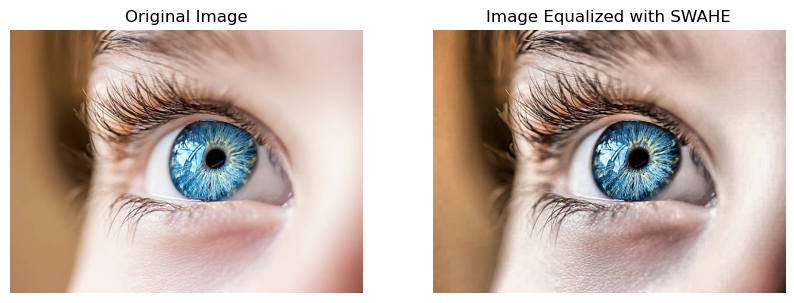

In [30]:
import urllib



# Load the image
img_path = 'images/blue_eye.jpeg'
img = cv2.imread(img_path)

if img is None:
    print("Failed to load image.")
else:
    # Convert to hsv color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply CLAHE to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv[:, :, 2] = clahe.apply(hsv[:, :, 2])

    

    # Convert back to BGR color space
    img_clahe = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Save the result image
    cv2.imwrite('images/blue_eye_2.jpg', img_clahe)

    # Show original and modified image
    plt.figure(figsize=(10, 5))  # Set figure size for better visibility
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Image Equalized with SWAHE')
    plt.axis('off')

    plt.show()

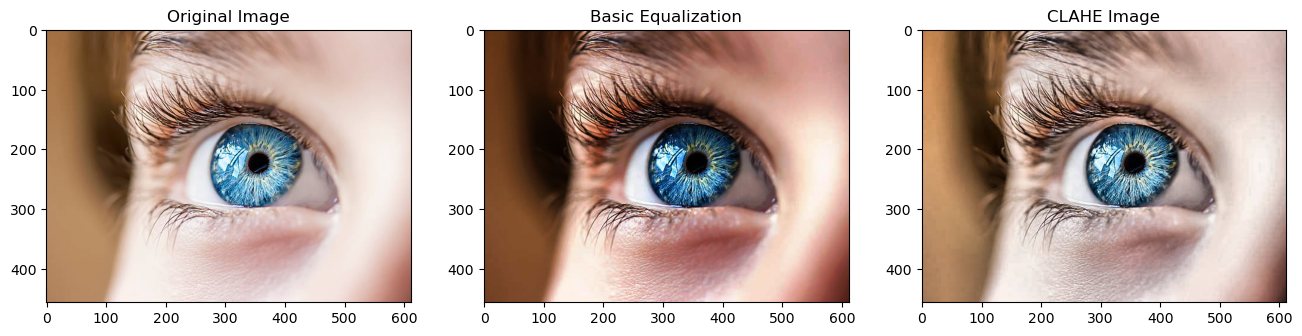

In [34]:

fig = plt.figure(figsize=(16, 8))

# 1) Original Image
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
a.set_title('Original Image')

# 2) Image Equalized with basic equalizer
# Perform basic equalization
original_image_eq = exposure.equalize_hist(img)
original_image_eq_ubyte = img_as_ubyte(original_image_eq)  # Convert to uint8

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow( cv2.cvtColor(original_image_eq_ubyte,cv2.COLOR_BGR2RGB))
a.set_title('Basic Equalization')

# 3) Image with CLAHE (assuming 'img_clahe' is already an equalized BGR image)
# No conversion needed if img_clahe is correctly processed and in BGR format
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))
a.set_title('CLAHE Image')

plt.show()


<h3>Lest try with a black and white image</h3>

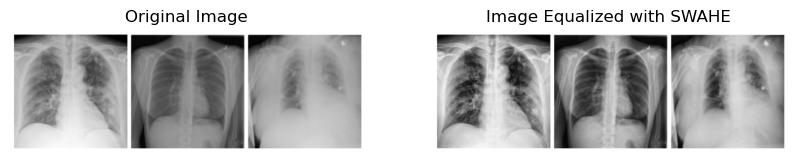

In [35]:



# Load the image
img_path = 'images/Torax.png'
img = cv2.imread(img_path)

if img is None:
    print("Failed to load image.")
else:
    # Convert to hsv color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply CLAHE to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv[:, :, 2] = clahe.apply(hsv[:, :, 2])

    

    # Convert back to BGR color space
    img_clahe = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Save the result image
    cv2.imwrite('images/blue_eye_2.jpg', img_clahe)

    # Show original and modified image
    plt.figure(figsize=(10, 5))  # Set figure size for better visibility
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Image Equalized with SWAHE')
    plt.axis('off')

    plt.show()

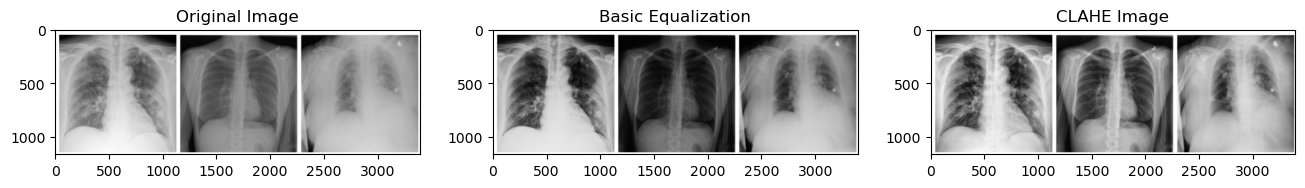

In [36]:
fig = plt.figure(figsize=(16, 8))

# 1) Original Image
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
a.set_title('Original Image')

# 2) Image Equalized with basic equalizer
# Perform basic equalization
original_image_eq = exposure.equalize_hist(img)
original_image_eq_ubyte = img_as_ubyte(original_image_eq)  # Convert to uint8

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow( cv2.cvtColor(original_image_eq_ubyte,cv2.COLOR_BGR2RGB))
a.set_title('Basic Equalization')

# 3) Image with CLAHE (assuming 'img_clahe' is already an equalized BGR image)
# No conversion needed if img_clahe is correctly processed and in BGR format
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB))
a.set_title('CLAHE Image')

plt.show()



<h3>Bibliography</h3>
Part 1:

<p><li>GeeksforGeeks. (2021, November 22). Adaptive histogram equalization in image processing using MATLAB. GeeksforGeeks. Retrieved January 25, 2023, from https://www.geeksforgeeks.org/adaptive-histogram-equalization-in-image-processing-using-matlab/ </li></p>


<p><li>Contrast Limited adaptive histogram equalization. Contrast Limited Adaptive Histogram Equalization - MATLAB &amp; Simulink - MathWorks 中国. (n.d.). Retrieved January 25, 2023, from https://ww2.mathworks.cn/help/visionhdl/ug/contrast-adaptive-histogram-equalization.html </li></p>


<p><li>Wikimedia Foundation. (2022, October 12). Adaptive histogram equalization. Wikipedia. Retrieved January 25, 2023, from https://en.wikipedia.org/wiki/Adaptive_histogram_equalization </li></p>

Part 3:
<p><li>Gonzalez, R. C., & Woods, R. E. (2018). Digital Image Processing (4th ed.). Prentice-Hall.</li></p>
<p><li>
Khan, M. A., & Khan, M. R. (2015). Contrast Limited Adaptive Histogram Equalization (CLAHE) Approach for Enhancement of the Microstructures of Friction Stir Welded Joints. Journal of Materials Engineering and Performance, 24(5), 2039-2046. doi: 10.1007/s11665-014-1329-9</li></p>
<p><li>Wikipedia. (2023). Adaptive Histogram Equalization. Retrieved from https://en.wikipedia.org/wiki/Adaptive_histogram_equalization</li></p>
